In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xg

import warnings
warnings.filterwarnings("ignore")

In [10]:
data = pd.read_csv("/kaggle/input/cassandra23-ps-2/dataset/train_data.csv")
test = pd.read_csv("/kaggle/input/cassandra23-ps-2/dataset/test_data.csv")
data

,UID,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time
0,lWYYrbNEdf,2018-09-15 02:23:18.656742,thanos::sroute:9d8ed3f7-a8af-4393-ad7a-c57a720...,FTL,trip-153697819865649878,IND832109AAB,Jamshedpur_Central_I_3 (Jharkhand),IND834002AAB,Ranchi_Hub (Jharkhand),2018-09-15 02:23:18.656742,...,2018-09-15 04:45:23,158.807515,778.672716,1228.735753,2.782826,77.988686,20.793472,28.475783,3.292773,100.0
1,iNJcHQlPCm,2018-09-30 15:07:48.971326,thanos::sroute:b9142a73-d68f-46ec-9afc-d145479...,FTL,trip-153832006897106333,IND422011AAD,Nashik_TgrniaRD_I (Maharashtra),IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),2018-09-30 22:38:13.903069,...,2018-10-01 05:38:30,81.388109,227.479029,NaN,3.625248,68.517914,18.787231,34.612259,4.277350,61.0
2,U6N0M43qwR,2018-09-23 22:15:46.635975,thanos::sroute:883e99fa-50a3-40e0-a2e2-9b12ed6...,FTL,trip-153774094663572416,IND845305AAA,Raxaul_KairiyaT_D (Bihar),NaN,Muzaffrpur_Bbganj_I (Bihar),2018-09-24 03:56:37.016232,...,2018-09-24 09:21:30,134.486898,400.072069,1188.943158,4.415969,70.475386,24.371978,29.867950,5.322072,69.0
3,RrJUneuYNj,2018-09-21 05:11:44.833176,thanos::sroute:96a80600-40e1-436b-9161-fa68f9e...,FTL,trip-153750670483274503,IND842001AAA,Muzaffrpur_Bbganj_I (Bihar),IND854326AAB,Purnia_Central_H_2 (Bihar),2018-09-22 10:08:32.593022,...,2018-09-22 14:09:17,262.866674,510.123878,999.421258,2.946647,101.876844,19.588977,27.794019,4.265799,300.0
4,7QLdD7iRC9,2018-09-18 01:10:49.936747,thanos::sroute:b43ec86d-59c1-452c-b4a9-807d357...,FTL,trip-153723305402762987,IND411033AAA,Pune_Tathawde_H (Maharashtra),IND501359AAE,Hyderabad_Shamshbd_H (Telangana),2018-09-18 01:10:49.936747,...,2018-09-18 12:14:05,379.389280,NaN,NaN,1.998790,46.571301,22.671495,26.971844,3.553652,286.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72153,dNuV95njhn,2018-09-29 12:35:30.065739,thanos::sroute:ace9e650-93bd-49ab-9400-8ed7a29...,FTL,trip-153822453006548340,IND501359AAE,Hyderabad_Shamshbd_H (Telangana),IND585104AAA,Gulbarga_Nehrugnj_I (Karnataka),2018-09-29 12:35:30.065739,...,2018-09-29 20:08:31,135.001150,NaN,1392.622148,1.950803,55.856356,39.233287,46.999351,1.383605,92.0
72154,ZSrzBfWx77,2018-09-22 11:00:33.571928,thanos::sroute:34b3abb5-f538-4f43-bbeb-5b12c1a...,Carting,trip-153761403357161860,IND562132AAA,Bangalore_Nelmngla_H (Karnataka),IND560083AAB,Bengaluru_Bnnrghta_L (Karnataka),2018-09-22 11:00:33.571928,...,2018-09-22 13:11:21,74.245265,374.255819,NaN,1.927801,35.976514,13.607794,15.139818,1.456469,30.0
72155,XsIYBRVK2V,2018-09-14 23:01:12.630742,thanos::sroute:16dbdb8b-1ca6-4d26-a45c-18d378e...,FTL,trip-153696607263047584,IND629179AAA,Marthandam_Nallur_D (Tamil Nadu),IND627005AAA,Tirunelveli_VdkkuSrt_I (Tamil Nadu),2018-09-15 04:20:06.629681,...,2018-09-15 06:53:24,54.097087,895.612578,902.191591,2.148569,44.101033,23.355458,27.510588,2.346207,74.0
72156,6YwMOShK5E,2018-09-22 06:11:41.998188,thanos::sroute:23372931-5898-4276-970b-0df5070...,FTL,trip-153759670199790692,IND110037AAM,Delhi_Airport_H (Delhi),IND282001AAA,Agra_Idgah_P (Uttar Pradesh),2018-09-22 06:11:41.998188,...,2018-09-22 15:42:27,99.918631,NaN,1393.905281,2.206373,37.771823,18.740087,29.929128,2.499566,122.0


In [11]:
data.columns

Index(['UID', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'osrm_time',
       'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance', 'segment_factor', 'actual_time'],
      dtype='object')

In [12]:
relevant_features = ["trip_creation_time", "start_scan_to_end_scan", "segment_actual_time", "actual_distance_to_destination","is_cutoff","route_type", "osrm_time", "osrm_distance", "cutoff_factor", "segment_osrm_time", "segment_osrm_distance", "actual_time"]
data2 = data[relevant_features]
relevant_features.remove("actual_time")
test2 = test[relevant_features]
data2

,trip_creation_time,start_scan_to_end_scan,segment_actual_time,actual_distance_to_destination,is_cutoff,route_type,osrm_time,osrm_distance,cutoff_factor,segment_osrm_time,segment_osrm_distance,actual_time
0,2018-09-15 02:23:18.656742,713.521495,77.988686,158.807515,True,FTL,778.672716,1228.735753,44,20.793472,28.475783,100.0
1,2018-09-30 15:07:48.971326,902.759458,68.517914,81.388109,True,FTL,227.479029,NaN,22,18.787231,34.612259,61.0
2,2018-09-23 22:15:46.635975,923.666146,70.475386,134.486898,True,FTL,400.072069,1188.943158,22,24.371978,29.867950,69.0
3,2018-09-21 05:11:44.833176,705.451567,101.876844,262.866674,True,FTL,510.123878,999.421258,176,19.588977,27.794019,300.0
4,2018-09-18 01:10:49.936747,1109.682268,46.571301,379.389280,True,FTL,NaN,NaN,198,22.671495,26.971844,286.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72153,2018-09-29 12:35:30.065739,1132.865742,55.856356,135.001150,True,FTL,NaN,1392.622148,66,39.233287,46.999351,92.0
72154,2018-09-22 11:00:33.571928,355.951299,35.976514,74.245265,True,Carting,374.255819,NaN,18,13.607794,15.139818,30.0
72155,2018-09-14 23:01:12.630742,737.899031,44.101033,54.097087,True,FTL,895.612578,902.191591,44,23.355458,27.510588,74.0
72156,2018-09-22 06:11:41.998188,845.738186,37.771823,99.918631,True,FTL,NaN,1393.905281,88,18.740087,29.929128,122.0


In [13]:
data2.isna().sum() 

trip_creation_time                 3515
start_scan_to_end_scan                0
segment_actual_time                   0
actual_distance_to_destination        0
is_cutoff                             0
route_type                            0
osrm_time                         14432
osrm_distance                     14432
cutoff_factor                         0
segment_osrm_time                     0
segment_osrm_distance                 0
actual_time                           0
dtype: int64

In [14]:
data2["osrm_distance"].fillna(data2["osrm_distance"].mean(), inplace = True)
data2["osrm_time"].fillna(data2["osrm_time"].mean(), inplace = True)
data2

,trip_creation_time,start_scan_to_end_scan,segment_actual_time,actual_distance_to_destination,is_cutoff,route_type,osrm_time,osrm_distance,cutoff_factor,segment_osrm_time,segment_osrm_distance,actual_time
0,2018-09-15 02:23:18.656742,713.521495,77.988686,158.807515,True,FTL,778.672716,1228.735753,44,20.793472,28.475783,100.0
1,2018-09-30 15:07:48.971326,902.759458,68.517914,81.388109,True,FTL,227.479029,869.045744,22,18.787231,34.612259,61.0
2,2018-09-23 22:15:46.635975,923.666146,70.475386,134.486898,True,FTL,400.072069,1188.943158,22,24.371978,29.867950,69.0
3,2018-09-21 05:11:44.833176,705.451567,101.876844,262.866674,True,FTL,510.123878,999.421258,176,19.588977,27.794019,300.0
4,2018-09-18 01:10:49.936747,1109.682268,46.571301,379.389280,True,FTL,645.031637,869.045744,198,22.671495,26.971844,286.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72153,2018-09-29 12:35:30.065739,1132.865742,55.856356,135.001150,True,FTL,645.031637,1392.622148,66,39.233287,46.999351,92.0
72154,2018-09-22 11:00:33.571928,355.951299,35.976514,74.245265,True,Carting,374.255819,869.045744,18,13.607794,15.139818,30.0
72155,2018-09-14 23:01:12.630742,737.899031,44.101033,54.097087,True,FTL,895.612578,902.191591,44,23.355458,27.510588,74.0
72156,2018-09-22 06:11:41.998188,845.738186,37.771823,99.918631,True,FTL,645.031637,1393.905281,88,18.740087,29.929128,122.0


In [15]:
route = pd.get_dummies(data2["route_type"])
test_route = pd.get_dummies(test2["route_type"])
route

,Carting,FTL
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
72153,False,True
72154,True,False
72155,False,True
72156,False,True


In [16]:
cutoff = pd.get_dummies(data2["is_cutoff"])
test_cutoff = pd.get_dummies(test2["is_cutoff"])
cutoff

,False,True
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
72153,False,True
72154,False,True
72155,False,True
72156,False,True


In [17]:
data2

,trip_creation_time,start_scan_to_end_scan,segment_actual_time,actual_distance_to_destination,is_cutoff,route_type,osrm_time,osrm_distance,cutoff_factor,segment_osrm_time,segment_osrm_distance,actual_time
0,2018-09-15 02:23:18.656742,713.521495,77.988686,158.807515,True,FTL,778.672716,1228.735753,44,20.793472,28.475783,100.0
1,2018-09-30 15:07:48.971326,902.759458,68.517914,81.388109,True,FTL,227.479029,869.045744,22,18.787231,34.612259,61.0
2,2018-09-23 22:15:46.635975,923.666146,70.475386,134.486898,True,FTL,400.072069,1188.943158,22,24.371978,29.867950,69.0
3,2018-09-21 05:11:44.833176,705.451567,101.876844,262.866674,True,FTL,510.123878,999.421258,176,19.588977,27.794019,300.0
4,2018-09-18 01:10:49.936747,1109.682268,46.571301,379.389280,True,FTL,645.031637,869.045744,198,22.671495,26.971844,286.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72153,2018-09-29 12:35:30.065739,1132.865742,55.856356,135.001150,True,FTL,645.031637,1392.622148,66,39.233287,46.999351,92.0
72154,2018-09-22 11:00:33.571928,355.951299,35.976514,74.245265,True,Carting,374.255819,869.045744,18,13.607794,15.139818,30.0
72155,2018-09-14 23:01:12.630742,737.899031,44.101033,54.097087,True,FTL,895.612578,902.191591,44,23.355458,27.510588,74.0
72156,2018-09-22 06:11:41.998188,845.738186,37.771823,99.918631,True,FTL,645.031637,1393.905281,88,18.740087,29.929128,122.0


In [18]:
data2['trip_creation_time'] = pd.to_datetime(data2['trip_creation_time'])
data2['unix_time'] = (data2['trip_creation_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
data2.drop("trip_creation_time",axis = 1, inplace = True)

test2['trip_creation_time'] = pd.to_datetime(test['trip_creation_time'])
test2['unix_time'] = (test2['trip_creation_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
test2.drop("trip_creation_time", axis = 1,inplace = True)

data2

,start_scan_to_end_scan,segment_actual_time,actual_distance_to_destination,is_cutoff,route_type,osrm_time,osrm_distance,cutoff_factor,segment_osrm_time,segment_osrm_distance,actual_time,unix_time
0,713.521495,77.988686,158.807515,True,FTL,778.672716,1228.735753,44,20.793472,28.475783,100.0,1.536978e+09
1,902.759458,68.517914,81.388109,True,FTL,227.479029,869.045744,22,18.787231,34.612259,61.0,1.538320e+09
2,923.666146,70.475386,134.486898,True,FTL,400.072069,1188.943158,22,24.371978,29.867950,69.0,1.537741e+09
3,705.451567,101.876844,262.866674,True,FTL,510.123878,999.421258,176,19.588977,27.794019,300.0,1.537507e+09
4,1109.682268,46.571301,379.389280,True,FTL,645.031637,869.045744,198,22.671495,26.971844,286.0,1.537233e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
72153,1132.865742,55.856356,135.001150,True,FTL,645.031637,1392.622148,66,39.233287,46.999351,92.0,1.538225e+09
72154,355.951299,35.976514,74.245265,True,Carting,374.255819,869.045744,18,13.607794,15.139818,30.0,1.537614e+09
72155,737.899031,44.101033,54.097087,True,FTL,895.612578,902.191591,44,23.355458,27.510588,74.0,1.536966e+09
72156,845.738186,37.771823,99.918631,True,FTL,645.031637,1393.905281,88,18.740087,29.929128,122.0,1.537597e+09


In [19]:
def column_normalize(column_name, df):
    df[f'normalized_{column_name}'] = (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())
    df.drop(column_name, axis = 1,inplace = True)
    return df

In [20]:
for column in ['start_scan_to_end_scan', 'segment_actual_time','actual_distance_to_destination', 'osrm_time', 'osrm_distance', 'cutoff_factor', 'segment_osrm_time','segment_osrm_distance', 'unix_time']:
    data2 = column_normalize(column, data2)
    
for column in ['start_scan_to_end_scan', 'segment_actual_time','actual_distance_to_destination', 'osrm_time', 'osrm_distance', 'cutoff_factor', 'segment_osrm_time','segment_osrm_distance','unix_time']:
    test2 = column_normalize(column, test2)
    
data2

,is_cutoff,route_type,actual_time,normalized_start_scan_to_end_scan,normalized_segment_actual_time,normalized_actual_distance_to_destination,normalized_osrm_time,normalized_osrm_distance,normalized_cutoff_factor,normalized_segment_osrm_time,normalized_segment_osrm_distance,normalized_unix_time
0,True,FTL,100.0,0.130023,0.095338,0.077147,0.239397,0.293058,0.018373,0.012851,0.012967,0.140881
1,True,FTL,61.0,0.166141,0.092466,0.037242,0.065293,0.206213,0.006824,0.011611,0.015761,0.846844
2,True,FTL,69.0,0.170132,0.093060,0.064611,0.119810,0.283451,0.006824,0.015063,0.013601,0.542166
3,True,FTL,300.0,0.128483,0.102584,0.130784,0.154571,0.237692,0.087664,0.012107,0.012656,0.418930
4,True,FTL,286.0,0.205635,0.085809,0.190845,0.197184,0.206213,0.099213,0.014012,0.012282,0.274959
...,...,...,...,...,...,...,...,...,...,...,...,...
72153,True,FTL,92.0,0.210060,0.088626,0.064876,0.197184,0.332628,0.029921,0.024250,0.021402,0.796581
72154,True,Carting,30.0,0.061776,0.082596,0.033560,0.111655,0.206213,0.004724,0.008409,0.006893,0.475396
72155,True,FTL,74.0,0.134676,0.085060,0.023175,0.276335,0.214216,0.018373,0.014435,0.012527,0.134502
72156,True,FTL,122.0,0.155258,0.083140,0.046793,0.197184,0.332938,0.041470,0.011582,0.013628,0.466278


In [21]:
data2 = pd.concat([data2, route, cutoff], axis = 1)
test2 = pd.concat([test2, test_route, test_cutoff], axis = 1)

data2.drop(["is_cutoff", "route_type"], axis = 1, inplace = True) # SINCE DUMMY DATAFRAME IS CONCATENATED
test2.drop(["is_cutoff", "route_type"], axis = 1, inplace = True)

data2.dropna(inplace = True)
data2.reset_index(inplace = True, drop = True)
data2

,actual_time,normalized_start_scan_to_end_scan,normalized_segment_actual_time,normalized_actual_distance_to_destination,normalized_osrm_time,normalized_osrm_distance,normalized_cutoff_factor,normalized_segment_osrm_time,normalized_segment_osrm_distance,normalized_unix_time,Carting,FTL,False,True
0,100.0,0.130023,0.095338,0.077147,0.239397,0.293058,0.018373,0.012851,0.012967,0.140881,False,True,False,True
1,61.0,0.166141,0.092466,0.037242,0.065293,0.206213,0.006824,0.011611,0.015761,0.846844,False,True,False,True
2,69.0,0.170132,0.093060,0.064611,0.119810,0.283451,0.006824,0.015063,0.013601,0.542166,False,True,False,True
3,300.0,0.128483,0.102584,0.130784,0.154571,0.237692,0.087664,0.012107,0.012656,0.418930,False,True,False,True
4,286.0,0.205635,0.085809,0.190845,0.197184,0.206213,0.099213,0.014012,0.012282,0.274959,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68638,92.0,0.210060,0.088626,0.064876,0.197184,0.332628,0.029921,0.024250,0.021402,0.796581,False,True,False,True
68639,30.0,0.061776,0.082596,0.033560,0.111655,0.206213,0.004724,0.008409,0.006893,0.475396,True,False,False,True
68640,74.0,0.134676,0.085060,0.023175,0.276335,0.214216,0.018373,0.014435,0.012527,0.134502,False,True,False,True
68641,122.0,0.155258,0.083140,0.046793,0.197184,0.332938,0.041470,0.011582,0.013628,0.466278,False,True,False,True


In [32]:
data2 = data2[["actual_time", 
            "normalized_start_scan_to_end_scan",
            "normalized_segment_actual_time",
            "normalized_actual_distance_to_destination",
            "normalized_osrm_time",
            "normalized_osrm_distance",
            "normalized_cutoff_factor",
            "normalized_segment_osrm_time",
            "normalized_segment_osrm_distance",
            "normalized_unix_time",
            "Carting",
            "FTL"]]

test2 = test2[["normalized_start_scan_to_end_scan",
            "normalized_segment_actual_time",
            "normalized_actual_distance_to_destination",
            "normalized_osrm_time",
            "normalized_osrm_distance",
            "normalized_cutoff_factor",
            "normalized_segment_osrm_time",
            "normalized_segment_osrm_distance",
            "normalized_unix_time",
            "Carting",
            "FTL"]]

In [33]:
x = data2.drop("actual_time", axis = 1)
y = data2["actual_time"]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.15, random_state=23)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((58346, 11), (58346,), (10297, 11), (10297,))

In [35]:
# LINEAR REGRESSION
model = LinearRegression()
model.fit(xtrain, ytrain)
model.score(xtest, ytest)

0.9676197876603357

In [36]:
# RANDOM FOREST REGRESSOR
model2 = RandomForestRegressor()
model2.fit(xtrain, ytrain)
model2.score(xtest, ytest)

0.9748244132754417

In [37]:
# KNN REGRESSOR
knn = KNeighborsRegressor()
knn.fit(xtrain, ytrain)
knn.score(xtest, ytest)

0.9643580198934645

In [38]:
# XG BOOST REGRESSOR
xgbr = xg.XGBRegressor(n_estimators = 100, seed = 123)
xgbr.fit(xtrain, ytrain)
xgbr.score(xtest, ytest)

0.9826117646893322

In [39]:
ypred1 = model.predict(xtest)
ypred2 = model2.predict(xtest)
ypred3 = knn.predict(xtest)
ypred4 = xgbr.predict(xtest)

df = pd.DataFrame({"YTRUE":ytest, "LINEAR REGRESSION":ypred1, "RANDOM FOREST": ypred2, "KNN REGRESSOR": ypred3, "XG BOOST": ypred4})
df.reset_index(inplace = True)
df.drop("index", axis = 1, inplace = True)
df.set_index("YTRUE", inplace = True)
df

,LINEAR REGRESSION,RANDOM FOREST,KNN REGRESSOR,XG BOOST
YTRUE,,,,
232.0,192.599577,290.20,232.4,264.557953
1967.0,2189.979543,2155.66,2086.8,2138.768555
394.0,389.924018,392.55,400.2,388.184052
232.0,239.831877,254.34,271.2,276.151031
21.0,53.354703,25.14,69.6,22.727699
...,...,...,...,...
34.0,7.616808,29.63,57.4,36.835514
571.0,747.071252,671.65,689.8,650.908264
12.0,34.522322,12.94,42.6,25.167288


In [40]:
rmse1 = math.sqrt(mean_squared_error(ytest, ypred1))
rmse2 = math.sqrt(mean_squared_error(ytest, ypred2))
rmse3 = math.sqrt(mean_squared_error(ytest, ypred3))
rmse4 = math.sqrt(mean_squared_error(ytest, ypred4))

In [41]:
performance = pd.DataFrame({
    "LinearRegression" : [model.score(xtest, ytest), rmse1],
    "RandomForestRegressor" : [model2.score(xtest, ytest), rmse2],
    "KNN REGRESSOR" : [knn.score(xtest, ytest), rmse3],
    "XGBRegressor" : [xgbr.score(xtest, ytest), rmse4]
},index = ["Accuracy Scores", "RMSE"]).T
performance

,Accuracy Scores,RMSE
LinearRegression,0.967620,107.865994
RandomForestRegressor,0.974824,95.111822
KNN REGRESSOR,0.964358,113.168514
XGBRegressor,0.982612,79.044646


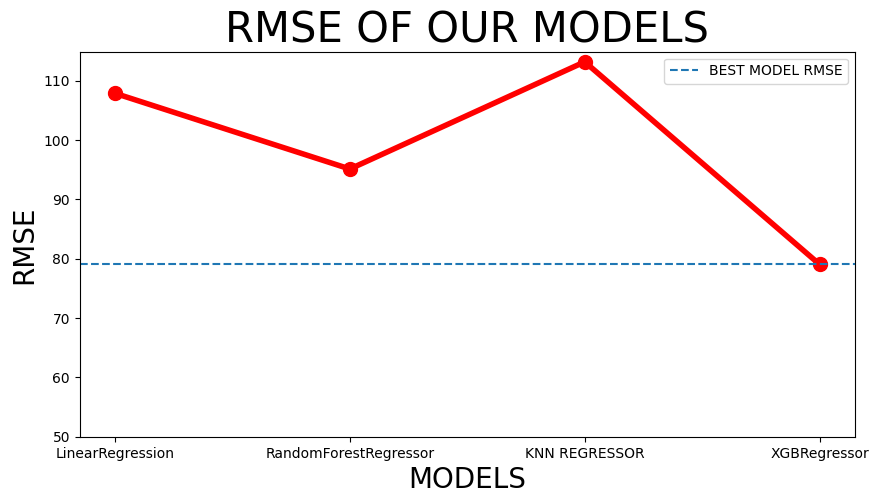

In [42]:
plt.figure(figsize = (10, 5))
plt.plot(performance.index, performance["RMSE"], linewidth = 4, color = "red", marker = "o", markersize = 10)
plt.xlabel("MODELS", size = 20)
plt.ylabel("RMSE", size = 20)
plt.title("RMSE OF OUR MODELS", size = 30)
plt.axhline(y = performance["RMSE"].min(), linestyle = "--", label = "BEST MODEL RMSE")
plt.legend()
plt.yticks(np.arange(50, 120, 10));

In [43]:
pred = xgbr.predict(test2)
submission = pd.DataFrame({"UID": test["UID"], "actual_time":pred})
submission.set_index("UID", inplace = True)
submission

,actual_time
UID,
XMsT9clviB,54.336975
1iUuyRUZ2Y,68.014999
wancwiAIU3,24.087168
1tIt8EwJjB,68.649284
W2vL6bJrjt,50.937790
...,...
L5IrEpNBFb,63.545673
s5TDXjnN3s,49.599319
0croXy5yK5,64.713005


In [46]:
submission.to_csv("submission.csv")